🔹 Cross-validation trên tập train:
Logistic Regression       | F1_macro: 0.8695 ± 0.0135 | Accuracy: 0.8669 ± 0.0134
Random Forest (depth=10)  | F1_macro: 0.9067 ± 0.0047 | Accuracy: 0.9066 ± 0.0039
Random Forest (depth=20)  | F1_macro: 0.9064 ± 0.0066 | Accuracy: 0.9066 ± 0.0065

📊 Evaluation on test set:

--- Logistic Regression ---
Accuracy: 0.8647058823529412
F1-weighted: 0.8651153781185208
              precision    recall  f1-score   support

    COVID-19       0.89      0.84      0.86       266
      NORMAL       0.91      0.89      0.90       188
   PNEUMONIA       0.81      0.88      0.84       226

    accuracy                           0.86       680
   macro avg       0.87      0.87      0.87       680
weighted avg       0.87      0.86      0.87       680


📈 Drawing Learning Curves...


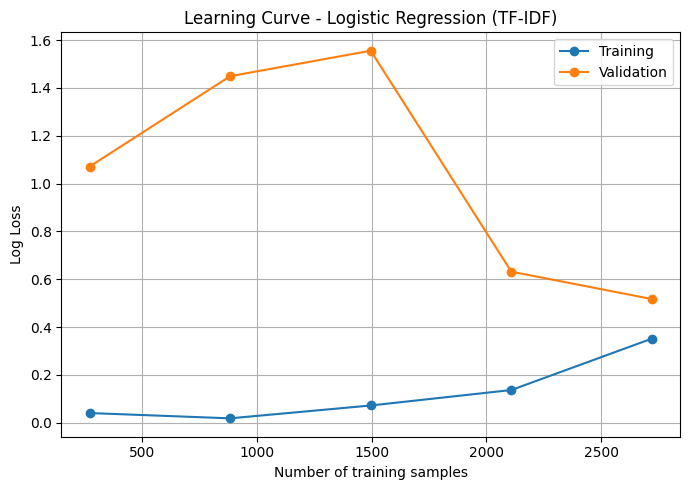

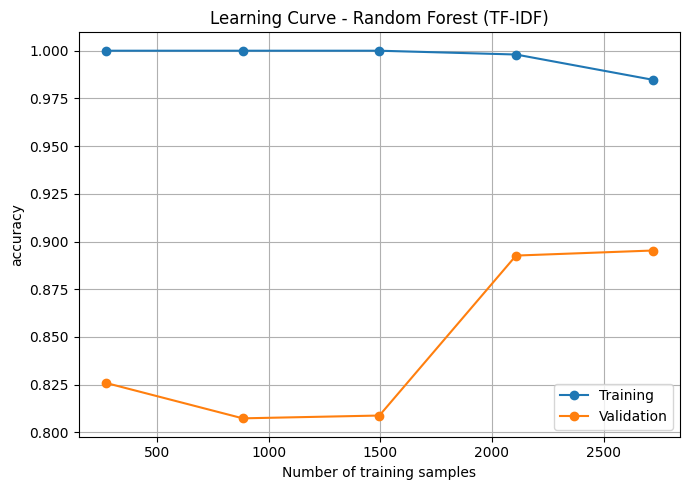

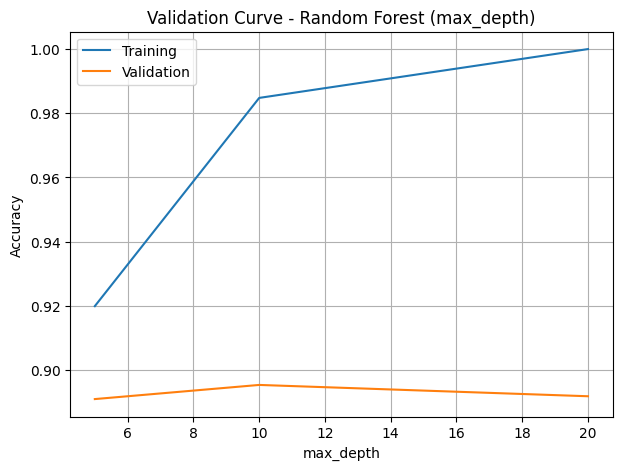


--- Random Forest ---
Accuracy: 0.8955882352941177
F1-weighted: 0.8954539399885812
              precision    recall  f1-score   support

    COVID-19       0.90      0.92      0.91       266
      NORMAL       0.90      0.86      0.88       188
   PNEUMONIA       0.88      0.89      0.89       226

    accuracy                           0.90       680
   macro avg       0.90      0.89      0.89       680
weighted avg       0.90      0.90      0.90       680


📈 Drawing Learning Curves...


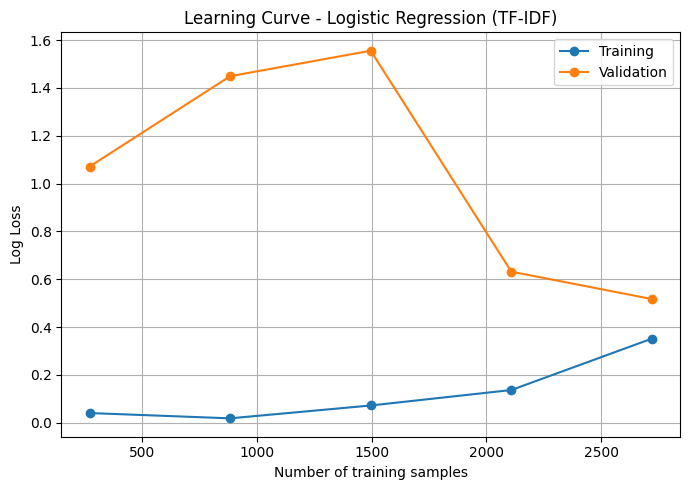

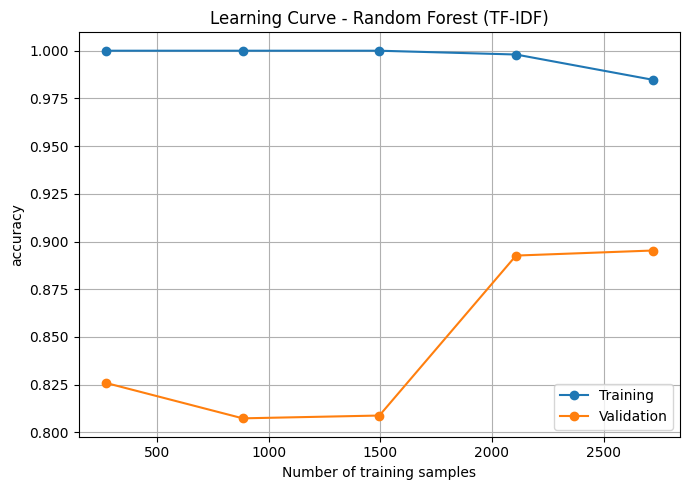

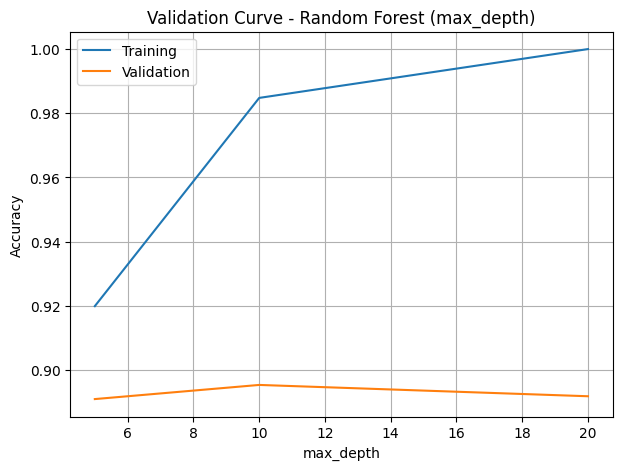

In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, make_scorer
)
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from scipy.sparse import hstack, csr_matrix
import joblib

def plot_learning_curve(
    model, X, y, title,
    scoring="accuracy",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5)
):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    # Nếu là log loss → đổi dấu
    if scoring == "neg_log_loss":
        train_mean = -train_mean
        val_mean = -val_mean
        ylabel = "Log Loss"
    else:
        ylabel = scoring

    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_mean, "o-", label="Training")
    plt.plot(train_sizes, val_mean, "o-", label="Validation")
    plt.xlabel("Number of training samples")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Xử lý dữ liệu & Tạo đặc trưng TF-IDF
def create_features_and_labels(dataset_path: str):
    df = pd.read_csv(dataset_path)
    
    numeric_cols = ["age", "temperature", "pO2 saturation"]
    categorical_cols = ["sex"]
    symptom_cols = ["cough", "fever", "healthy", "fatigue",
                    "shortness_of_breath", "chest_pain"]
    target_col = "finding"

    # Tạo text từ các triệu chứng
    def make_symptom_text(row):
        tokens = [col for col in symptom_cols if row[col] == 1]
        return " ".join(tokens) if tokens else "no_symptoms"

    df["symptoms_text"] = df.apply(make_symptom_text, axis=1)

    # Chuẩn hóa dữ liệu số
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[numeric_cols])

    # Mã hóa giới tính
    ohe = OneHotEncoder(sparse_output=True)
    X_cat = ohe.fit_transform(df[categorical_cols])

    # TF-IDF cho cột triệu chứng
    vectorizer = TfidfVectorizer()
    X_text = vectorizer.fit_transform(df["symptoms_text"])

    # Ghép các đặc trưng lại
    X = hstack([X_cat, csr_matrix(X_num), X_text], format="csr")

    # Encode nhãn
    le = LabelEncoder()
    y = le.fit_transform(df[target_col])

    return X, y, le, scaler, ohe, vectorizer





# Huấn luyện + Đánh giá model
def train_model(dataset_path: str):
    X, y, le, scaler, ohe, vectorizer = create_features_and_labels(dataset_path)

    # Chia tập train/test 80–20
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Các model cần so sánh
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs'),
        'Random Forest (depth=10)': RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42),
        'Random Forest (depth=20)': RandomForestClassifier(max_depth=20, n_estimators=100, random_state=42)
    }

    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_macro = make_scorer(f1_score, average='macro')

    print("🔹 Cross-validation trên tập train:")
    for name, model in models.items():
        scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_macro)
        scores_acc = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

        print(f"{name:25s} | F1_macro: {np.mean(scores_f1):.4f} ± {np.std(scores_f1):.4f} | "
              f"Accuracy: {np.mean(scores_acc):.4f} ± {np.std(scores_acc):.4f}")

        results[name] = {
            "CV_F1_macro_mean": float(np.mean(scores_f1)),
            "CV_F1_macro_std": float(np.std(scores_f1)),
            "CV_Accuracy_mean": float(np.mean(scores_acc)),
            "CV_Accuracy_std": float(np.std(scores_acc)),
        }

    # --- Evaluate test---
    print("\n📊 Evaluation on test set:")
    final_models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs'),
        "Random Forest": RandomForestClassifier(max_depth=20, n_estimators=100, random_state=42)
    }

    for name, model in final_models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

        print(f"\n--- {name} ---")
        print(f"Accuracy: {acc}")
        print(f"F1-weighted: {f1_weighted}")
        print(classification_report(y_test, y_pred, target_names=le.classes_))

        results[name + " (Test)"] = {
            "Accuracy": float(acc),
            "F1_weighted": float(f1_weighted),
            "Classification_Report": report
        }
        print("\n📈 Drawing Learning Curves...")
        lr_model = LogisticRegression(
            C=1,
            max_iter=1000,
            solver="lbfgs",
            multi_class="auto"
        )

        plot_learning_curve(
            model=lr_model,
            X=X,
            y=y,
            title="Learning Curve - Logistic Regression (TF-IDF)",
            scoring="neg_log_loss"
        )

        rf_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )

        plot_learning_curve(
            model=rf_model,
            X=X,
            y=y,
            title="Learning Curve - Random Forest (TF-IDF)",
            scoring="accuracy"
        )

        from sklearn.model_selection import validation_curve

        param_range = [5, 10, 20, None]

        train_scores, val_scores = validation_curve(
            RandomForestClassifier(n_estimators=100, random_state=42),
            X, y,
            param_name="max_depth",
            param_range=param_range,
            cv=5,
            scoring="accuracy"
        )

        plt.figure(figsize=(7, 5))
        plt.plot(param_range, np.mean(train_scores, axis=1), label="Training")
        plt.plot(param_range, np.mean(val_scores, axis=1), label="Validation")
        plt.xlabel("max_depth")
        plt.ylabel("Accuracy")
        plt.title("Validation Curve - Random Forest (max_depth)")
        plt.legend()
        plt.grid(True)
        plt.show()

       
        model_filename = f"../models/TF-IDF/tfidf_{name.lower().replace(' ', '_')}.pkl"
        joblib.dump(model, model_filename)

        # Save Model
        joblib.dump(vectorizer, "../models/TF-IDF/tfidf_vectorizer.pkl")
        joblib.dump(scaler, "../models/TF-IDF/tfidf_scaler.pkl")
        joblib.dump(ohe, "../models/TF-IDF/tfidf_onehot_encoder.pkl")
        joblib.dump(le, "../models/TF-IDF/tfidf_label_encoder.pkl")

    
        with open("../models/TF-IDF/results_tfidf.json", "w", encoding="utf-8") as f:
            json.dump(results, f, indent=4, ensure_ascii=False)

        print("\n Đã lưu kết quả và model vào file:")
        print("   - tfidf_logistic_regression.pkl")
        print("   - tfidf_random_forest.pkl")
        print("   - tfidf_vectorizer.pkl")
        print("   - tfidf_scaler.pkl")
        print("   - tfidf_onehot_encoder.pkl")
        print("   - tfidf_label_encoder.pkl")
        print("   - results_tfidf.json")
        print("\n Hoàn tất huấn luyện!")


if __name__ == "__main__":
    train_model("../../data/metadata.csv")

